In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [1]:
'''
Load and process OASIS brain data set

@author Aghnia Prawira (45610240)
'''

import tensorflow as tf

def decode_image(filename, is_seg=False):
    '''
    is_seg: if it is sge image
    '''
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=1)

    if is_seg:
        # The partition graph uses nearest neighbor interpolation to maintain discrete values
        image = tf.image.resize(image, (256, 256), method='nearest')
    else:
        image = tf.image.resize(image, (256, 256))

    return image

def process_image(image_path, seg_path):
    # Load and adjust graph size
    image = decode_image(image_path, is_seg=False)
    seg = decode_image(seg_path, is_seg=True)

    # Normalization
    image = image / 255.0

    # Convert the split graph into a category index
    seg = tf.round(seg)  # To nearest integer
    seg = tf.cast(seg, tf.int32)

    # Map the pixel values to the category index (0,1,2,3)
    seg = tf.where(seg == 0, 0, seg)
    seg = tf.where(seg == 85, 1, seg)
    seg = tf.where(seg == 170, 2, seg)
    seg = tf.where(seg == 255, 3, seg)

    # Convert to one-hot encoding (4 categories)
    seg = tf.one_hot(tf.squeeze(seg, axis=-1), depth=4)
    seg = tf.cast(seg, tf.float32)

    return image, seg

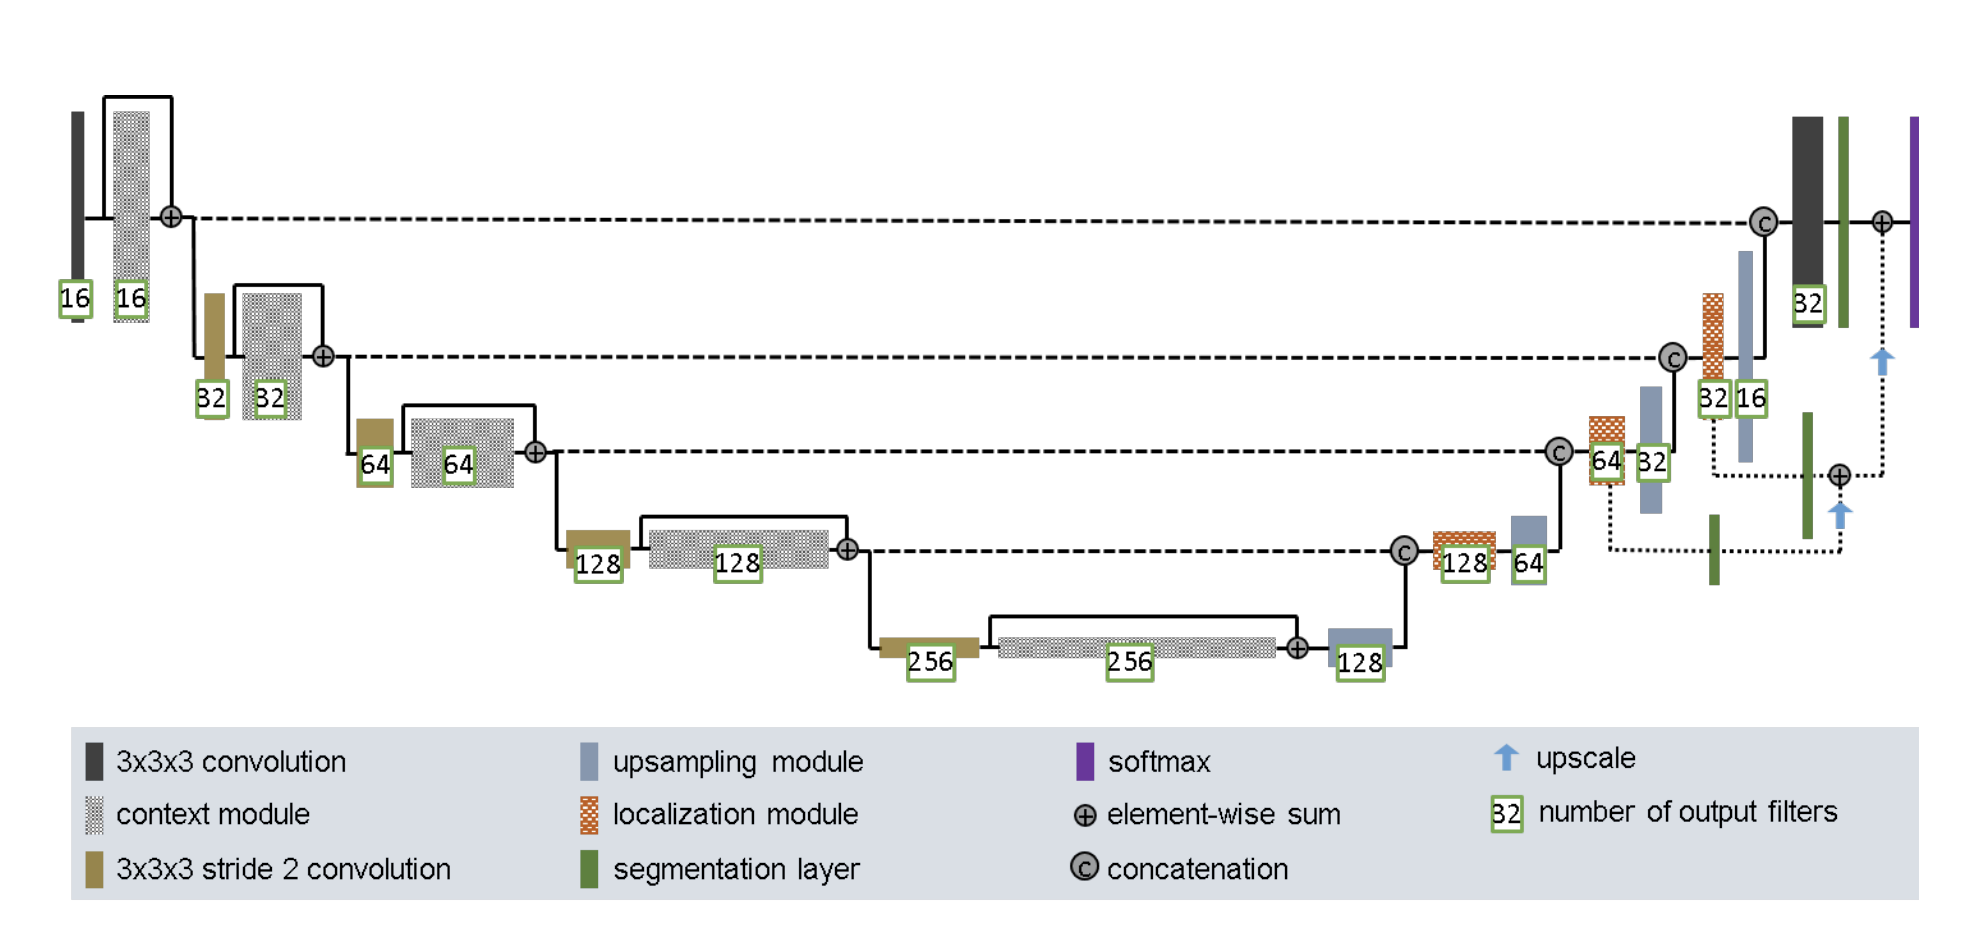

Defined by "Brain Tumor Segmentation and Radiomics Survival Prediction: Contribution to the BRATS 2017 Challenge" [1].

[1] F. Isensee, P. Kickingereder, W. Wick, M. Bendszus, and K. H. Maier-Hein, "Brain Tumor Segmentation and Radiomics Survival Prediction: Contribution to the BRATS 2017 Challenge," Feb. 2018. [Online]. Available: https://arxiv.org/abs/1802.10508v1

Add BatchNormalization to each convolutional layer to improve training efficiency

In [6]:
'''
Improved UNet model

@author Aghnia Prawira (45610240)
'''
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, Add, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model


def unet():
    inputs = Input(shape=(256, 256, 1))

    c0 = Conv2D(16, (3, 3), padding='same')(inputs)
    c0 = BatchNormalization()(c0)
    c0 = LeakyReLU(alpha=0.01)(c0)

    '''Conv 1'''
    # Context module
    c1 = Conv2D(16, (3, 3), padding='same')(c0)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.01)(c1)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(16, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.01)(c1)
    # Element-wise sum
    c1 = Add()([c0, c1])

    # Downsampling
    c1_down = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(c1)
    c1_down = BatchNormalization()(c1_down)
    c1_down = LeakyReLU(alpha=0.01)(c1_down)

    '''Conv 2'''
    # Context module
    c2 = Conv2D(32, (3, 3), padding='same')(c1_down)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.01)(c2)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(32, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)

    c2 = LeakyReLU(alpha=0.01)(c2)
    # Element-wise sum
    c2 = Add()([c1_down, c2])

    # Downsampling
    c2_down = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(c2)
    c2_down = BatchNormalization()(c2_down)
    c2_down = LeakyReLU(alpha=0.01)(c2_down)

    '''Conv 3'''
    # Context module
    c3 = Conv2D(64, (3, 3), padding='same')(c2_down)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU(alpha=0.01)(c3)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(64, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = LeakyReLU(alpha=0.01)(c3)
    # Element-wise sum
    c3 = Add()([c2_down, c3])

    # Downsampling
    c3_down = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(c3)
    c3_down = BatchNormalization()(c3_down)
    c3_down = LeakyReLU(alpha=0.01)(c3_down)

    '''Conv 4'''
    # Context module
    c4 = Conv2D(128, (3, 3), padding='same')(c3_down)
    c4 = BatchNormalization()(c4)
    c4 = LeakyReLU(alpha=0.01)(c4)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(128, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = LeakyReLU(alpha=0.01)(c4)
    # Element-wise sum
    c4 = Add()([c3_down, c4])

    # Downsampling
    c4_down = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(c4)
    c4_down = BatchNormalization()(c4_down)
    c4_down = LeakyReLU(alpha=0.01)(c4_down)

    '''Conv 5'''
    # Context module
    c5 = Conv2D(256, (3, 3), padding='same')(c4_down)
    c5 = BatchNormalization()(c5)
    c5 = LeakyReLU(alpha=0.01)(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = LeakyReLU(alpha=0.01)(c5)
    # Element-wise sum
    c5 = Add()([c4_down, c5])

    # Upsampling module
    u4 = UpSampling2D(size=(2, 2))(c5)

    '''Up 4'''
    # Concatenation
    u4 = concatenate([u4, c4])
    # Localization module
    u4 = Conv2D(128, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = LeakyReLU(alpha=0.01)(u4)
    u4 = Conv2D(128, (1, 1), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = LeakyReLU(alpha=0.01)(u4)

    # Upsampling module
    u3 = UpSampling2D(size=(2, 2))(u4)

    '''Up 3'''
    # Concatenation
    u3 = concatenate([u3, c3])
    # Localization module
    u3 = Conv2D(64, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = LeakyReLU(alpha=0.01)(u3)
    u3 = Conv2D(64, (1, 1), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = LeakyReLU(alpha=0.01)(u3)
    # Segmentation module
    s3 = Conv2D(4, (3, 3), padding='same')(u3) #4 categories
    s3 = BatchNormalization()(s3)
    s3 = LeakyReLU(alpha=0.01)(s3)
    s3 = UpSampling2D(size=(2, 2))(s3)

    # Upsampling module
    u2 = UpSampling2D(size=(2, 2))(u3)

    '''Up 2'''
    # Concatenation
    u2 = concatenate([u2, c2])
    # Localization module
    u2 = Conv2D(32, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = LeakyReLU(alpha=0.01)(u2)
    u2 = Conv2D(32, (1, 1), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = LeakyReLU(alpha=0.01)(u2)
    # Segmentation module
    s2 = Conv2D(4, (3, 3), padding='same')(u2)
    s2 = BatchNormalization()(s2)
    s2 = LeakyReLU(alpha=0.01)(s2)
    s3_2 = Add()([s3, s2])
    s3_2 = UpSampling2D(size=(2, 2))(s3_2)

    # Upsampling module
    u1 = UpSampling2D(size=(2, 2))(u2)

    '''Up 1'''
    # Concatenation
    u1 = concatenate([u1, c1])
    # Final conv layer
    u1 = Conv2D(32, (1, 1), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = LeakyReLU(alpha=0.01)(u1)
    # Segmentation module
    s1 = Conv2D(4, (3, 3), padding='same')(u1)
    s1 = BatchNormalization()(s1)
    s1 = LeakyReLU(alpha=0.01)(s1)
    # Element-wise sum
    s3_2_1 = Add()([s3_2, s1])

    outputs = Conv2D(4, (3, 3), padding='same', activation='softmax')(s3_2_1)
    model = Model(inputs, outputs)
    return model

def dice_coefficient(y_true, y_pred):
    '''
    Dice similarity coefficient (DSC) for each label (averaged over batch).
    '''
    smooth = 1e-6
    # Calculate intersaction and union set of each class

    intersection = k.sum(y_true * y_pred, axis=[0, 1, 2])
    union = k.sum(y_true, axis=[0, 1, 2]) + k.sum(y_pred, axis=[0, 1, 2])

    #Calculate the Dice coefficient of each class
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_coefficient_avg(y_true, y_pred):
    '''
    Average DSC of all labels.
    '''
    coefficient = k.mean(dice_coefficient(y_true, y_pred))
    return coefficient

def dice_loss(y_true, y_pred):
    '''
    Loss: 1 - average DSC
    '''
    loss = 1.0 - dice_coefficient_avg(y_true, y_pred)
    return loss

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow version: 2.19.0
Loading and processing images ...
Generating model ...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 256, 256,  │      2,320 │ leaky_re_lu_25[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256, 256,  │          0 │ leaky_re_lu_26[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_5[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_27      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 256, 256,  │          0 │ leaky_re_lu_25[0… │
│                     │ 16)               │            │ leaky_re_lu_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │      4,640 │ add_7[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      9,248 │ leaky_re_lu_28[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_30[0][0] 

 Total params: 2,581,456 (9.85 MB)

 Trainable params: 2,577,496 (9.83 MB)

 Non-trainable params: 3,960 (15.47 KB)

Compiling model ...
Training model ...
Epoch 1/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 69s 82ms/step - dice_coefficient_avg: 0.5659 - loss: 0.6199 - val_dice_coefficient_avg: 0.8209 - val_loss: 0.1292
Epoch 2/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - dice_coefficient_avg: 0.8867 - loss: 0.0714 - val_dice_coefficient_avg: 0.8461 - val_loss: 0.1369
Epoch 3/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - dice_coefficient_avg: 0.9100 - loss: 0.0560 - val_dice_coefficient_avg: 0.8138 - val_loss: 0.2009
Epoch 4/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - dice_coefficient_avg: 0.9226 - loss: 0.0476 - val_dice_coefficient_avg: 0.8347 - val_loss: 0.1817
Epoch 5/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - dice_coefficient_avg: 0.9299 - loss: 0.0430 - val_dice_coefficient_avg: 0.8723 - val_loss: 0.1284
Epoch 6/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - dice_coefficient_avg: 0.9348 - loss: 0.0399 - val_dice_coefficient_avg: 0.8722 - val_loss: 0.1287
Epoch 7/30
484/484 ━━━━━━━━━━━━━━━━━━

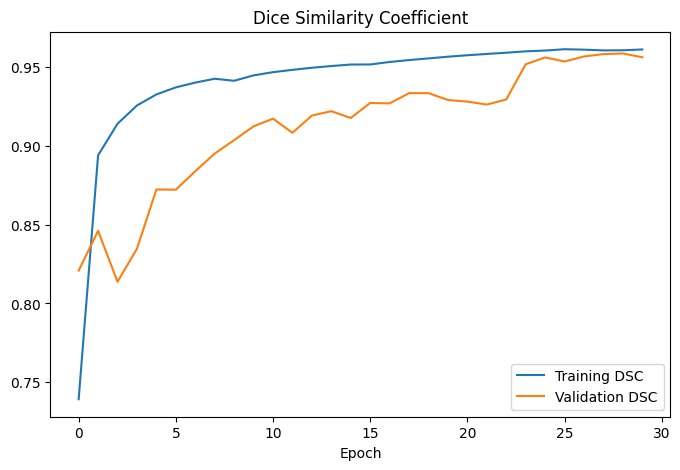

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Average DSC for all labels:  0.960261047
DSC for each label:  [0.998558 0.934593916 0.941449821 0.966442406]


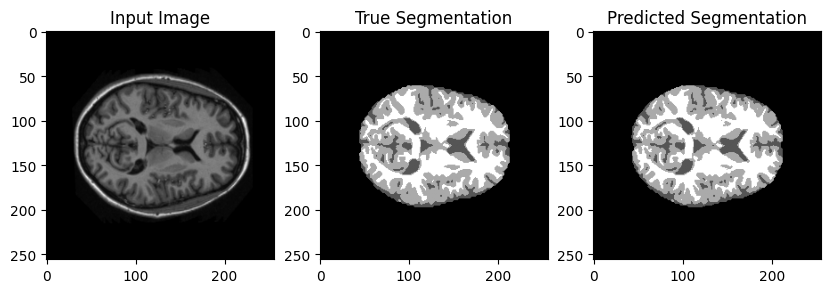

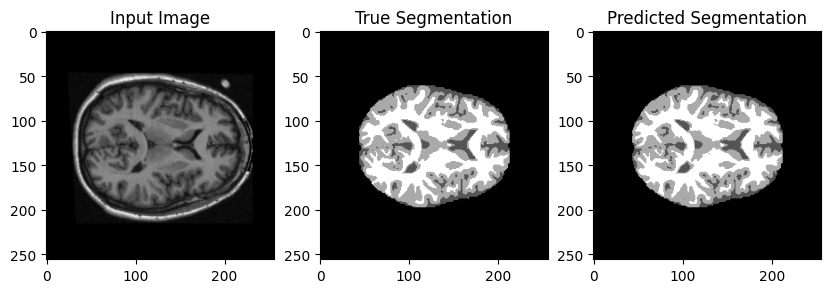

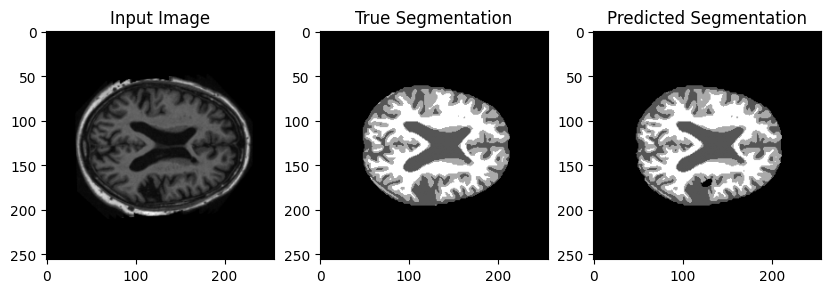

In [7]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

from glob import glob
# import data_processing as dp
# import improved_unet as iu
import matplotlib.pyplot as plt
import random
import tensorflow as tf

import sys
print('Python version:', sys.version)
print('TensorFlow version:', tf.__version__)

# Set path to dataset
dataset_path = "/content/drive/MyDrive/OASIS/"

seg_test_path = sorted(glob(dataset_path + "keras_png_slices_seg_test/*.png"))
seg_train_path = sorted(glob(dataset_path + "keras_png_slices_seg_train/*.png"))
seg_val_path = sorted(glob(dataset_path + "keras_png_slices_seg_validate/*.png"))
test_path = sorted(glob(dataset_path + "keras_png_slices_test/*.png"))
train_path = sorted(glob(dataset_path + "keras_png_slices_train/*.png"))
val_path = sorted(glob(dataset_path + "keras_png_slices_validate/*.png"))


# Create tensorflow dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_path, seg_train_path))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, seg_val_path))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, seg_test_path))


print("Loading and processing images ...")
# Load and process images
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)
test_ds = test_ds.map(process_image)

test, seg_test = next(iter(test_ds.batch(len(test_path))))


print("Generating model ...")
# Generate improved unet model
model = unet()
model.summary()


print("Compiling model ...")
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=[dice_coefficient_avg])


print("Training model ...")
# Train the model
history = model.fit(train_ds.batch(20),
                    epochs=30,
                    validation_data=val_ds.batch(20))


# Plot the training and validation DSC
plt.figure(figsize=(8, 5))
plt.title("Dice Similarity Coefficient")
plt.plot(history.history["dice_coefficient_avg"], label="Training DSC")
plt.plot(history.history["val_dice_coefficient_avg"], label="Validation DSC")
plt.xlabel("Epoch")
plt.legend();
plt.show()


# Calculate DSC
prediction = model.predict(test)
tf.print("Average DSC for all labels: ", dice_coefficient_avg(seg_test, prediction))
tf.print("DSC for each label: ", dice_coefficient(seg_test, prediction))


# Display random predictions
def display(title_list, image_list, cmap='viridis'):
    fig, ax = plt.subplots(1, len(title_list), figsize=(10, 10))
    for j, k in enumerate(title_list):
        ax[j].set_title(k)
    for j, k in enumerate(image_list):
        ax[j].imshow(k, cmap=cmap)
    plt.show()

random_images = [random.randint(1,len(test)) for i in range(3)]

for i in random_images:
    display(['Input Image', 'True Segmentation', 'Predicted Segmentation'],
            [test[i][:,:,0], tf.argmax(seg_test[i], axis=-1), tf.argmax(prediction[i], axis=-1)], cmap='gray')

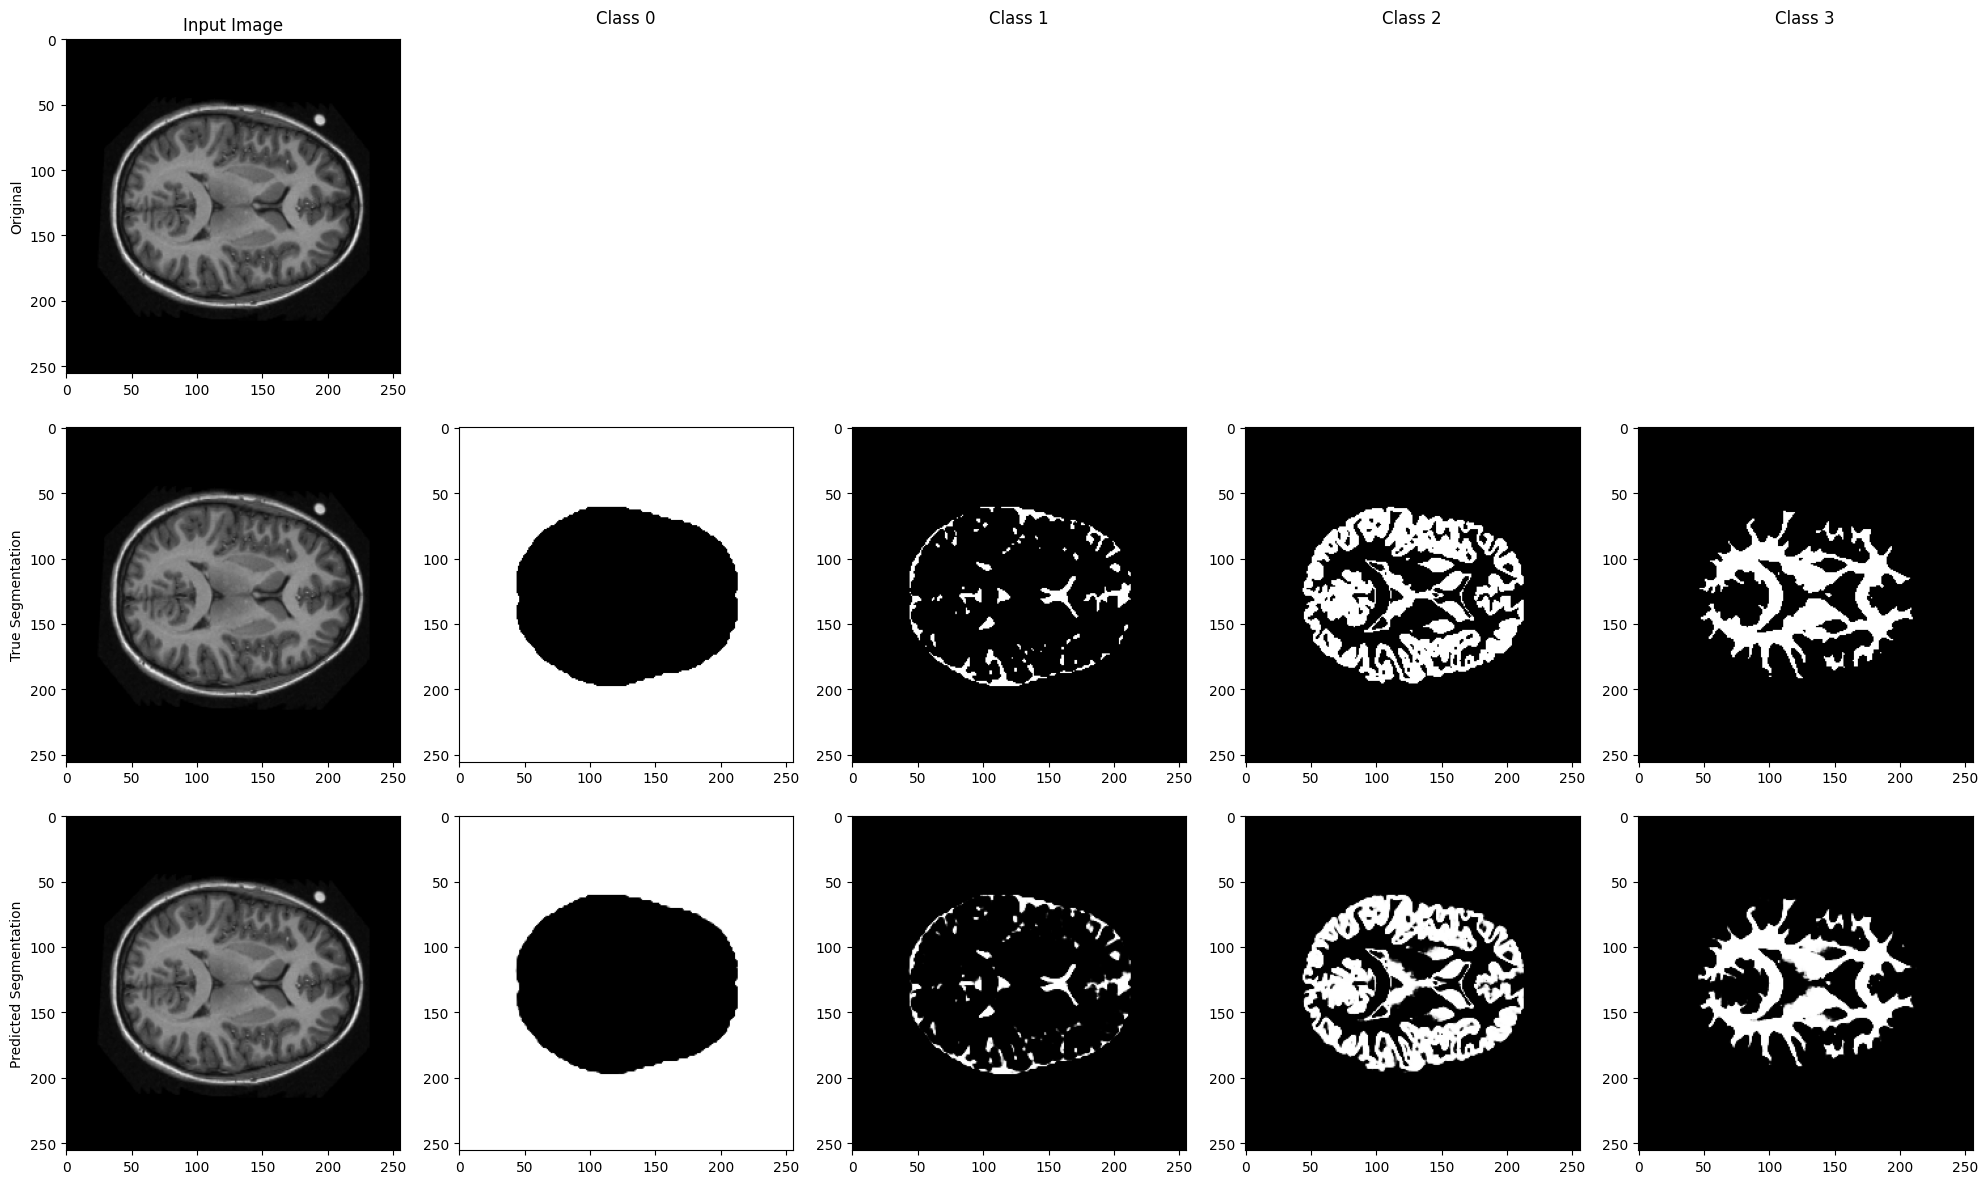

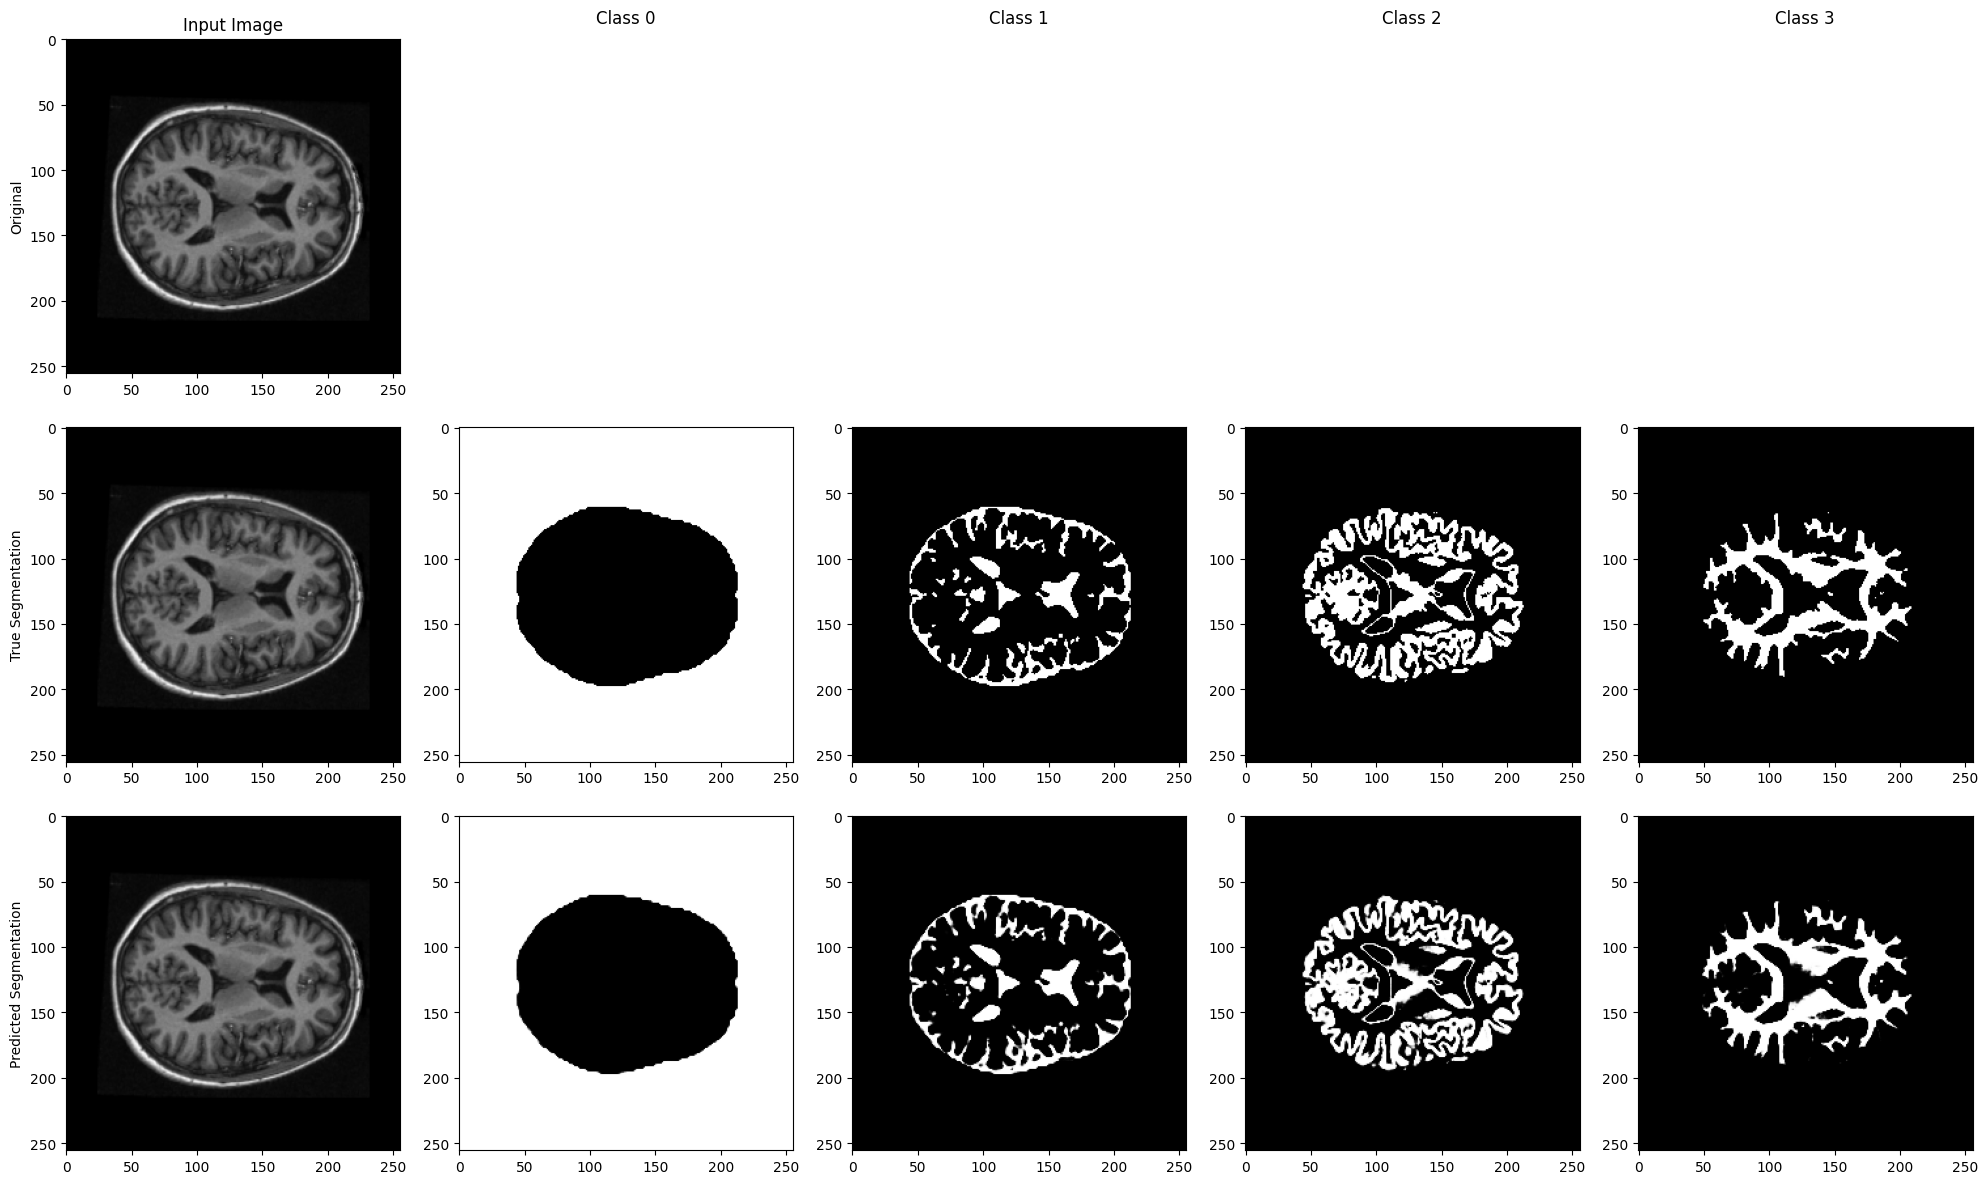

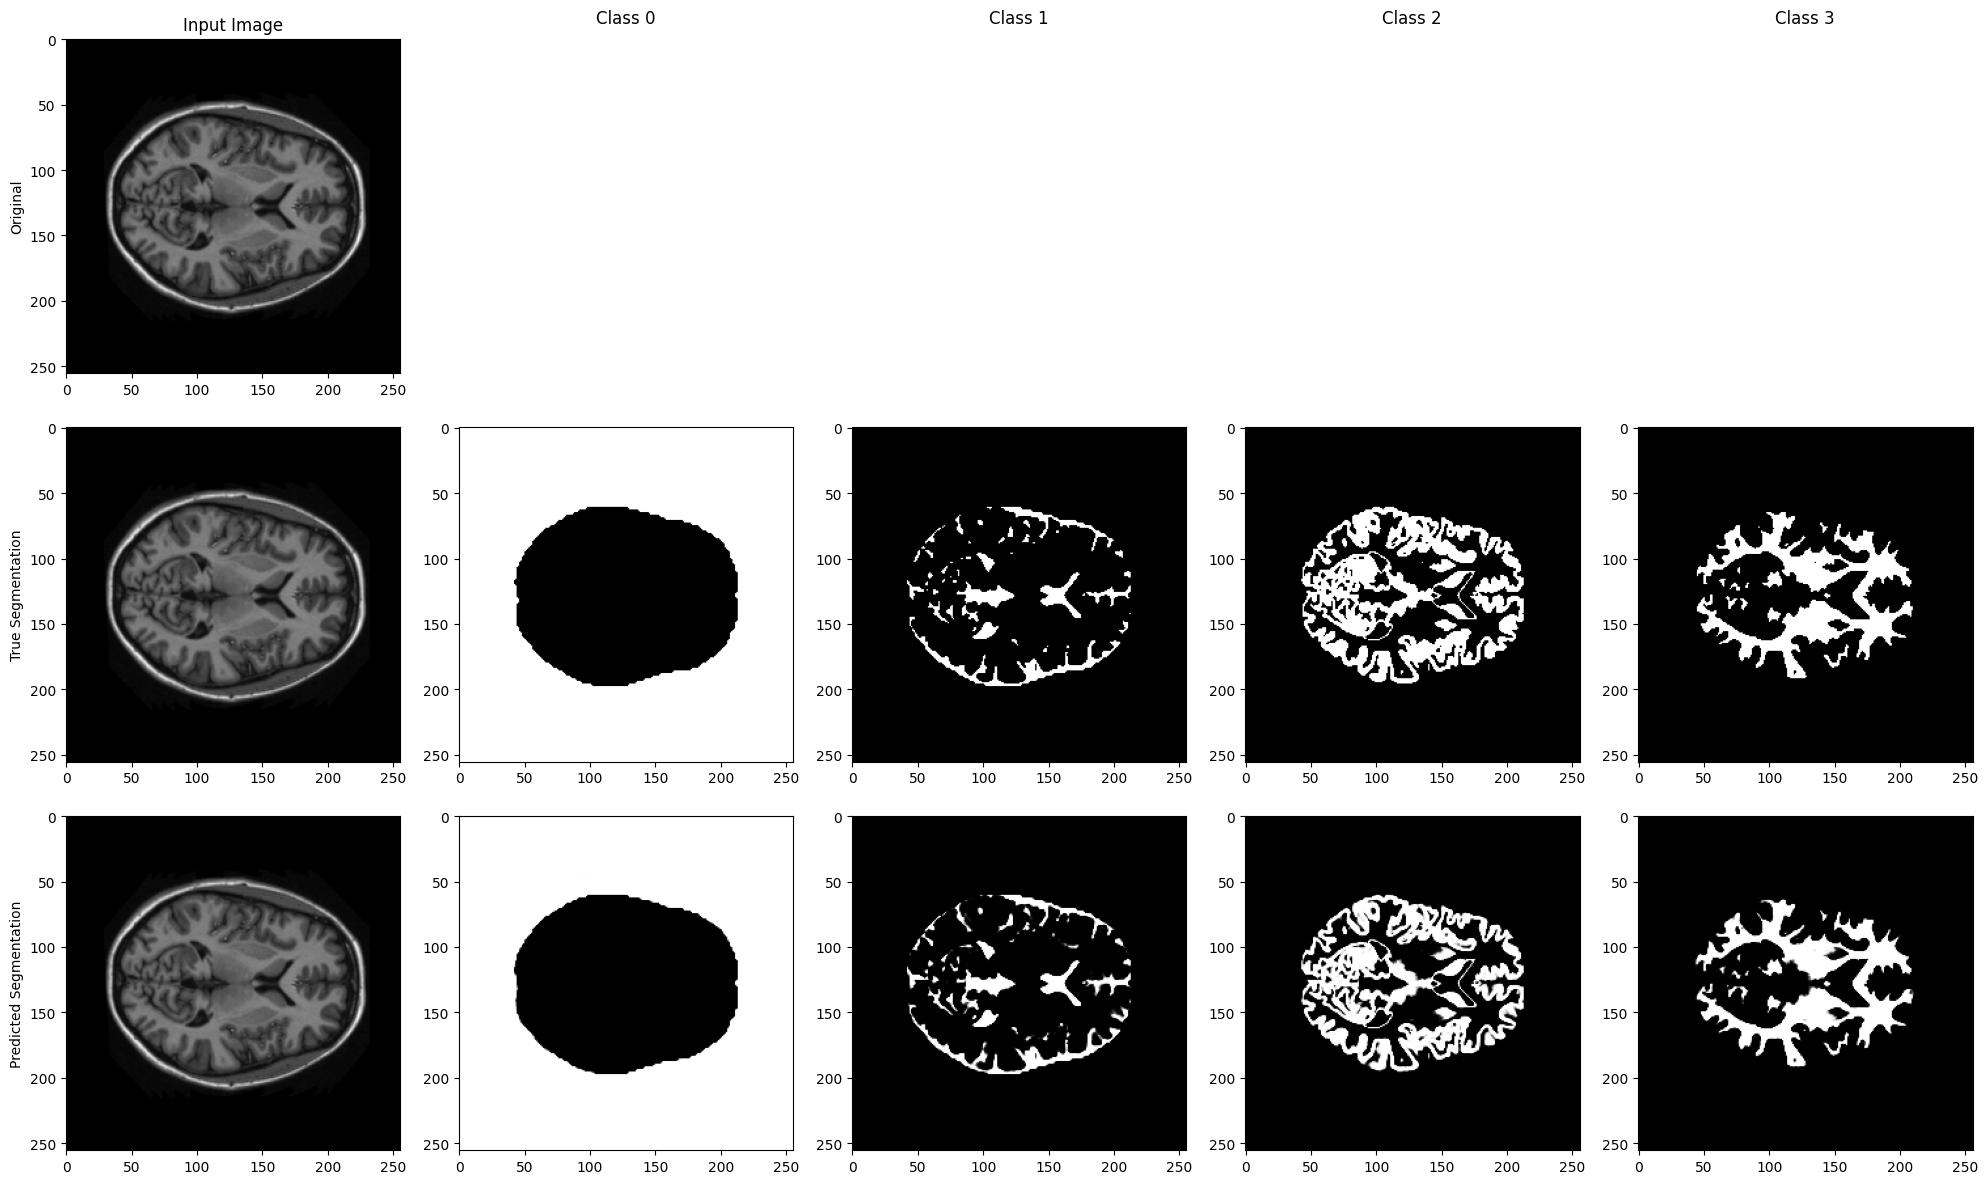

In [8]:
# Display random predictions
def display_comparison(image_list, cmap='viridis'):
    fig, axs = plt.subplots(3, 5, figsize=(20, 12))

    axs[0,0].set_title('Input Image')
    for i in range(4):
        axs[0,i+1].set_title(f'Class {i}')

    axs[0,0].set_ylabel('Original')
    axs[1,0].set_ylabel('True Segmentation')
    axs[2,0].set_ylabel('Predicted Segmentation')

    # Original image
    axs[0,0].imshow(image_list[0][:,:,0], cmap='gray')
    for i in range(4):
        axs[0,i+1].axis('off')

    # True segmentation
    axs[1,0].imshow(image_list[0][:,:,0], cmap='gray')
    for i in range(4):
        axs[1,i+1].imshow(image_list[1][:,:,i], cmap=cmap)

    # Predicted segmentation
    axs[2,0].imshow(image_list[0][:,:,0], cmap='gray')
    for i in range(4):
        axs[2,i+1].imshow(image_list[2][:,:,i], cmap=cmap)

    plt.tight_layout()
    plt.show()

random_images = [random.randint(1,len(test)) for i in range(3)]

for i in random_images:
    display_comparison(
        [test[i], seg_test[i], prediction[i]],
        cmap='gray'
    )